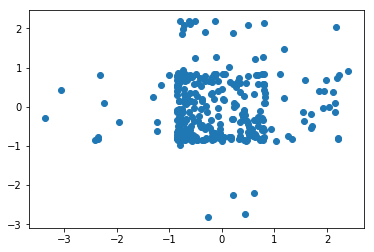

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_tasks(p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
    '''
    d: dimensionality
    c: scaling factor
    p: correlation
    n: number of data points
    '''
    assert d >= 2, "at least 2 dimension"    
    u1, u2 = np.zeros(d), np.zeros(d)
    u1[0] = 1
    u2[1] = 1
    w1 = c * u1
    w2 = c * (p * u1 + np.sqrt(1-p**2) * u2)
    
    X = []
    Y1 = []
    Y2 = []
    for _ in range(n):
        x = np.random.normal(0, 1, d)
        y1 = w1.dot(x) + np.random.normal(0,0.01)
        y2 = w2.dot(x) + np.random.normal(0,0.01)
        for a, b in zip(alphas, betas):
            y1 += np.sin(a * w1.dot(x) + b)
            y2 += np.sin(a * w2.dot(x) + b)
            
        X.append(x)
        Y1.append(y1)
        Y2.append(y2)
    return np.vstack(X), np.array(Y1), np.array(Y2)

X, Y1, Y2 = generate_tasks(p=0,c=1,alphas=[1,2],betas=[3,4])

plt.scatter(Y1, Y2)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.show()

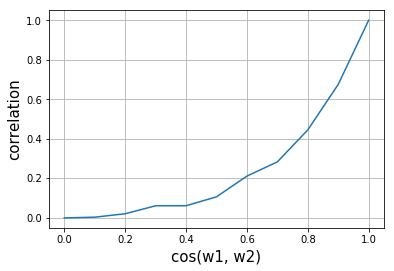

In [2]:
corr = []
pspace = np.linspace(0,1,11)
for p in pspace:
    X, Y1, Y2 = generate_tasks(p=p, n=10000,
                               c=1,
                               alphas=[1,2],
                               betas=[3,4])
    corr.append(np.corrcoef(Y1, Y2)[0,1])
    
plt.plot(pspace, corr)
plt.ylabel('correlation', fontsize=15)
plt.xlabel('cos(w1, w2)', fontsize=15)
plt.grid()
plt.show()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader  
from torch.utils.data import Dataset

class CosDataset(Dataset):
    
    def __init__(self, p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
        '''
        d: dimensionality
        c: scaling factor
        p: correlation
        n: number of data points
        '''
        self.X, self.Y1, self.Y2 = generate_tasks(p=p,d=d,c=c,n=n,
                                                  alphas=alphas,betas=betas)
        self.X = torch.from_numpy(self.X).float()
        
    def __len__(self):
        return len(self.Y1)
    
    def __getitem__(self, idx):
        return self.X[idx], (self.Y1[idx], self.Y2[idx])
    
    
def MTL_loss():
    
    def c(yhat, y):
        # regression loss on 2 tasks
        y1, y2 = y
        yhat1, yhat2 = yhat
        c_ = torch.nn.MSELoss()
        return c_(yhat1.view(-1), y1.float().view(-1)) + c_(yhat2.view(-1), y2.float().view(-1))
        
    return c


In [4]:
from torch.utils.data import DataLoader
cos_sim = 0
n = 10000
alphas = [1, 2]
betas = [3, 4]
train_data = DataLoader(CosDataset(p=cos_sim, n=n, alphas=alphas, betas=betas), batch_size=min(1000, n))
val_data = DataLoader(CosDataset(p=cos_sim, n=n, alphas=alphas, betas=betas), batch_size=min(1000, n))

## RK4 optimizer

In [6]:
from torch.optim import Optimizer
from torch.optim.optimizer import required
import math 
from lib.optimizer import RK4, DoublingRK4, Diff, DiffMax, AdamUnbiased, DiffUnbiased
from lib.model import Independent, SharedBottom, MMOE
from lib.train import TrainFeedForward

def loadTrainer(loadname, net):
    t = TrainFeedForward(net,
                         DataLoader(CosDataset(1)))
    t.load_checkpoint(loadname)
    return t


# on mld3

In [294]:
torch.set_num_threads(1)

optimizers = [
    #torch.optim.Adam,
    #torch.optim.Adadelta,
    #torch.optim.Adamax,
    #torch.optim.ASGD,
    #torch.optim.SGD,
    #RK4,
    #DoublingRK4,
    #Diff,
    DiffUnbiased,
    #AdamUnbiased,
    #DiffMax, # slows down 
]

trainers = []
for opt in optimizers:
    net = Independent(1)
    #net = SharedBottom(3)
    optimizer = opt(net.parameters(), lr=1e-3)
    opt_name = opt.__name__
    print(opt_name)
    
    t = TrainFeedForward(net, train_data, val_data=val_data, criterion=MTL_loss(), n_iters=1000,
                         save_filename='optimizers/{}.pth.tar'.format(opt_name), n_save=30, optimizer=optimizer)
    trainers.append(t)
    t.train()

per layer neuron: 68
DiffUnbiased
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation loss
==> validation loss is 1.491
             10|             1%|          0m 0s|        0.04013|        0.01336|        1.40488
             20|             2%|          0m 0s|        0.02739|        0.00968|        1.38841
             30|             3%|          0m 0s|        0.02299|        0.00845|        1.37167
==> evaluating validation loss
==> validation loss is 1.351
             40|             4%|          0m 1s|        0.02225|        0.00820|        1.35036
             50|             5%|          0m 1s|        0.02074|        0.00785|        1.32131
             60|             6%|          0m 1s|        0.01961|        0.00754|        1.28614
==> evaluating validation loss
==> validation loss is 1.029
             70|             7%|          0m 1s|        0.01954|        0.00792|        1.24311
             80|  

per layer neuron: 68
=> loading checkpoint 'optimizers/SGD.pth.tar'
=> loaded checkpoint 'optimizers/SGD.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/AdamUnbiased.pth.tar'
=> loaded checkpoint 'optimizers/AdamUnbiased.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/Adamax.pth.tar'
=> loaded checkpoint 'optimizers/Adamax.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/DiffUnbiased.pth.tar'
=> loaded checkpoint 'optimizers/DiffUnbiased.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/DoublingRK4.pth.tar'
=> loaded checkpoint 'optimizers/DoublingRK4.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/Diff.pth.tar'
=> loaded checkpoint 'optimizers/Diff.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/Adam.pth.tar'
=> loaded checkpoint 'optimizers/Adam.pth.tar' (iteration 1001)


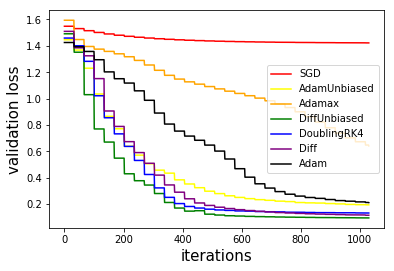

In [53]:
colors = ['r', 'yellow', 'orange', 'g', 'blue', 'purple', 'k', 'pink', 'brown', 'cyan']
i = 0
for fn in glob.glob('optimizers/*.tar'):
    k = fn.split('/')[-1].split('.')[0]  
    if 'best' not in fn and k in ['Adam', 'Diff', 'AdamUnbiased', 'SGD', 'Adamax', 'DoublingRK4', 'DiffUnbiased']:
        net = Independent(1)
        t = loadTrainer(fn, net)
        plt.plot(t.val_losses, label=k, color=colors[i])
        i+=1
        
plt.legend()
plt.xlabel('iterations', fontsize=15)
plt.ylabel('validation loss', fontsize=15)
plt.savefig('')
plt.show()

In [169]:
import glob
res = {}
cos_sim = 0.0 # 0.0 0.2 0.4 0.6 0.8 1.0
alpha = 0.1 # 0.1 0.5 1.0
for i in range(1,11):
    for fn in glob.glob('mtl_models/independent3/{}/c={}/a={}/*'.format(i, cos_sim, alpha)):
        if 'best' not in fn:
            net = Independent(3) #SharedBottom(4)
            t = loadTrainer(fn, net)
            
            opt_name = fn.split('/')[-1].split('.')[0]
            if res.get(opt_name) is not None:
                res[opt_name].append(t.val_losses)
            else:
                res[opt_name] = [t.val_losses]

per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/SGD.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/SGD.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/Adadelta.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/Adadelta.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/Adam.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/Adam.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/AdamUnbiased.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/AdamUnbiased.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/ASGD.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/1/c=0.0/a=0.1/ASGD.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 

=> loaded checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/Adam.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/AdamUnbiased.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/AdamUnbiased.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/ASGD.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/ASGD.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/Diff.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/Diff.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/RK4.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/RK4.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/6/c=0.0/a=0.1/DoublingRK4.pth.tar'
=> loaded checkpoint 'mtl_models/independent

=> loading checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/Diff.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/Diff.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/RK4.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/RK4.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/DoublingRK4.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/DoublingRK4.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/DiffMax.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/DiffMax.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/DiffUnbiased.pth.tar'
=> loaded checkpoint 'mtl_models/independent3/10/c=0.0/a=0.1/DiffUnbiased.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint

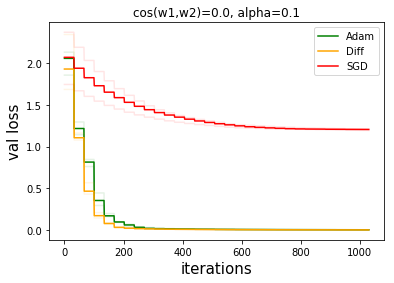

In [170]:
colors = ['red', 'purple', 'g', 'yellow', 'blue', 'orange', 'k', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items(),key=lambda a: a[0])):
    if k in ['Adam', 'Diff', 'SGD']: #['Adam', 'Diff', 'SGD', 'Adamax', 'DoublingRK4']:
        try:
            plt.plot(np.percentile(v, 50, 0), label=k, c=colors[i])
            plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
            plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
        except:
            print(k, len(v))

plt.legend()
plt.ylabel('val loss', fontsize=15)
plt.xlabel('iterations', fontsize=15)
plt.title('cos(w1,w2)={}, alpha={}'.format(cos_sim, alpha))
#plt.savefig('opt_figures/p={},a={}.png'.format(cos_sim, alpha))
plt.show()


# mld4

Avrng-0.0001: 98.27% (0.00)
Avrng-0.001: 98.36% (0.00)
Avrng-0.01: 98.54% (0.00)
Avrng-0.1: 98.46% (0.00)
Avrng-1.0: 98.38% (0.00)
Avrng-1e-05: 98.05% (0.00)
SGD-0.0001: 53.89% (0.00)
SGD-0.001: 84.19% (0.00)
SGD-0.01: 92.28% (0.00)
SGD-0.1: 97.46% (0.00)
SGD-1e-05: 12.21% (0.00)
average over 1 runs


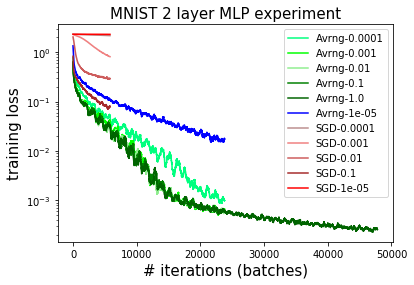

In [19]:
import glob
import matplotlib.pyplot as plt
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/feedforward_neural_network/train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('^')[0]
    if k.split('-')[0] not in ['SGD', 'Avrng']: #['SGD', 'Adam']:#, ['Avrng', 'Diff', 'AdamVR']:
        continue
    
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 200))
    acc = float('.'.join(fn.split('/')[-1].split('^.')[-1].split('.')[:-1]))
    accs[k].append(acc)

# report
colors = ['springgreen', 'lime', 'lightgreen', 'green', 'darkgreen','blue',
          'rosybrown', 'lightcoral', 'indianred', 'brown', 'red', 'orange']
for i, (k, v) in enumerate(sorted(res.items())):
    print('{}: {:.2f}% ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('average over {} runs'.format(len(v)))
plt.legend()
plt.title('MNIST 2 layer MLP experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    

Adam: 92.40% (0.08)
Avrng: 92.20% (0.10)
Diff: 92.46% (0.06)
average over 8 runs


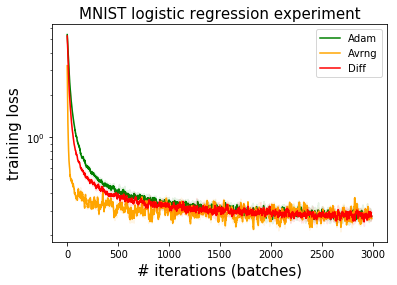

In [202]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/feedforward_neural_network/lr_train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 10))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['g', 'orange', 'red', 'g', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    print('{}: {:.2f}% ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('average over {} runs'.format(len(v)))
plt.legend()
plt.title('MNIST logistic regression experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    

Adam: 97.82% (0.17)
Avrng: 97.96% (0.09)
Diff: 97.87% (0.07)
average over 5 runs


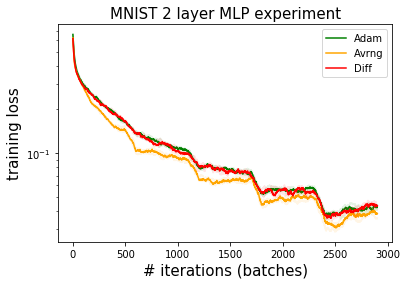

In [206]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/feedforward_neural_network/mlp_train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 100))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['g', 'orange', 'red', 'g', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    print('{}: {:.2f}% ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('average over {} runs'.format(len(v)))
plt.legend()
plt.title('MNIST 2 layer MLP experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    

Adam: 99.01% (0.18)
Diff: 99.06% (0.10)


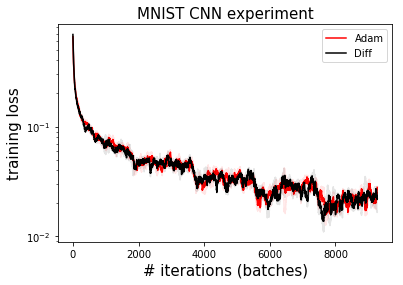

In [95]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/convolutional_neural_network/train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 100))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['red', 'black', 'orange', 'g', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    print('{}: {:.2f}% ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

plt.legend()
plt.title('MNIST CNN experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    

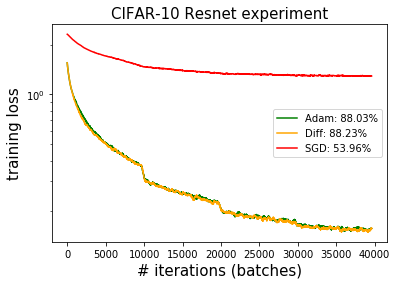

In [183]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

colors = {
    'Adam': 'g',
    'SGD': 'r',
    'Diff': 'orange',
}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/deep_residual_network/old_train_loss/1/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]    
    if k in ['Adam', 'Diff', 'SGD']:    
        acc = '.'.join(fn.split('/')[-1].split('.')[1:-1])
        train_losses = joblib.load(fn)

        #plt.plot(smooth(train_losses,100), label='{}: {}%'.format(k, acc))
        plt.semilogy(smooth(train_losses,400), label='{}: {}%'.format(k, acc), color=colors[k])

plt.legend()
plt.title('CIFAR-10 Resnet experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    

Adam: 74.28% (2.18)
Diff: 74.28% (2.81)


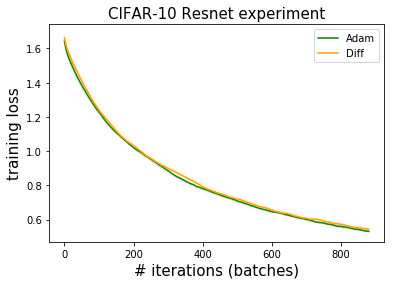

In [179]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/deep_residual_network/bs512_train_loss/*.train_losses')):    
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 100))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['g', 'orange', 'orange', 'red', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    if k in ['Adam', 'Diff', 'SGD']:
        print('{}: {:.2f}% ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
        plt.plot(np.percentile(v, 50, 0), label=k, c=colors[i])
        plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
        plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

plt.legend()
plt.title('CIFAR-10 Resnet experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    


Adam: 39.91% (1.10)
Diff: 39.80% (0.82)
SGD: 15.92% (1.41)
Graph averaged over 10 runs


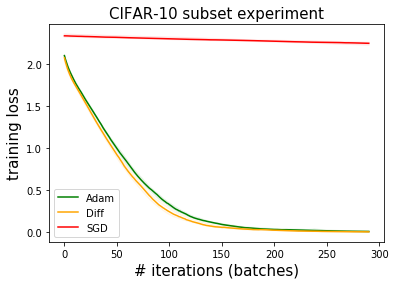

In [173]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/CIFAR10_limited/bs512_train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 10))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['g', 'orange', 'orange', 'red', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    if k in ['Adam', 'Diff', 'SGD']:
        print('{}: {:.2f}% ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
        plt.plot(np.percentile(v, 50, 0), label=k, c=colors[i])
        plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
        plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('Graph averaged over {} runs'.format(len(v)))
plt.legend()
plt.title('CIFAR-10 subset experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    


Adam loss: 11.55 (14.37)
Diff loss: 0.72 (1.20)
DiffUnbiasedBounded loss: 0.22 (0.05)
SGD loss: 0.25 (0.09)
Graph averaged over 30 runs


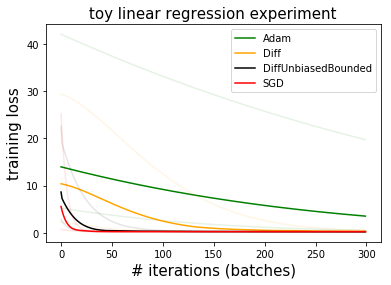

In [197]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/linear_regression/train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 1))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['g', 'orange', 'black', 'red', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    print('{} loss: {:.2f} ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.plot(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('Graph averaged over {} runs'.format(len(v)))
plt.legend()
plt.title('toy linear regression experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    


Adam loss: 14374.87 (12.13)
Diff loss: 14342.83 (21.48)
DiffUnbiasedBounded loss: 14466.03 (42.41)
Graph averaged over 5 runs


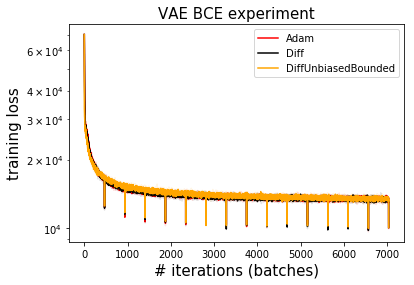

In [121]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/03-advanced/variational_autoencoder/train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 1))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['red', 'black', 'orange', 'g', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    print('{} loss: {:.2f} ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('Graph averaged over {} runs'.format(len(v)))
plt.legend()
plt.title('VAE BCE experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    


Adam loss: 4223.76 (10.44)
Diff loss: 4230.03 (8.29)
DiffUnbiasedBounded loss: 6072.85 (226.33)
Graph averaged over 1 runs


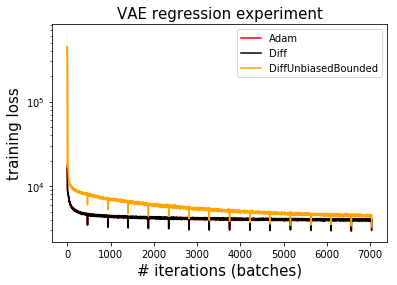

In [120]:
import glob
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

# collect
res = {}
accs = {}
for fn in sorted(glob.glob('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/03-advanced/VAE_regression/train_loss/*.train_losses')):
    k = fn.split('/')[-1].split('.')[0]
    if not res.get(k):
        res[k] = []
        accs[k] = []
    res[k].append(smooth(joblib.load(fn), 1))
    acc = float('.'.join(fn.split('/')[-1].split('.')[1:-1]))
    accs[k].append(acc)

# report
colors = ['red', 'black', 'orange', 'g', 'blue', 'yellow', 'purple', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items())):
    if 'SGD' in k: continue
    print('{} loss: {:.2f} ({:.2f})'.format(k, np.mean(accs[k]), np.std(accs[k])))
    plt.semilogy(np.percentile(v, 50, 0), label=k, c=colors[i])
    plt.semilogy(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
    plt.semilogy(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])

print('Graph averaged over {} runs'.format(len(v)))
plt.legend()
plt.title('VAE regression experiment', fontsize=15)
plt.ylabel('training loss', fontsize=15)
plt.xlabel('# iterations (batches)', fontsize=15)
plt.show()
    


# ODE solver